In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import math
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal

In [17]:
'''
rates and angles come in as a list of arrays, with each array of angles being one the 7 anaotomical angles ['ankle', 'knee', 'hip', 'limbfoot', 'elbow', 'shoulder', 'forelimb']

1. peaks are identified and the angle is converted to phase
    phase is converted to a sine and cosine wave

the winer filter is trained to take reformatted neural data and turn it into a prediction of sine and cosine

2. predicted sine and cosine are used to find the angle of phase via arctan2
'''
def phase_train(rates, angles):
    full_rates, full_angles = session512.stitch_and_format(rates, angles)
    peak_list0 = tailored_peaks(full_angles, 0)
    peak_list1 = tailored_peaks(full_angles, 1)
    peak_list2 = tailored_peaks(full_angles, 2)
    peak_list3 = tailored_peaks(full_angles, 3)
    peak_list4 = tailored_peaks(full_angles, 4)
    peak_list5 = tailored_peaks(full_angles, 5)
    peak_list6 = tailored_peaks(full_angles, 6)
    phase_list0 = to_phasex(peak_list0, full_angles[:,0])
    phase_list1 = to_phasex(peak_list1, full_angles[:,1])
    phase_list2 = to_phasex(peak_list2, full_angles[:,2])
    phase_list3 = to_phasex(peak_list3, full_angles[:,3])
    phase_list4 = to_phasex(peak_list4, full_angles[:,4])
    phase_list5 = to_phasex(peak_list5, full_angles[:,5])
    phase_list6 = to_phasex(peak_list6, full_angles[:,6])
    phase_list = np.vstack((phase_list0,phase_list1,phase_list2,phase_list3,phase_list4,phase_list5,phase_list6)).T
    sin_array, cos_array = sine_and_cosine(phase_list)
    h, _, _, _ = decode_kfolds(X=full_rates, Y=full_angles)
    h_sin, _, _, _ = decode_kfolds(X=full_rates, Y=sin_array)
    h_cos, _, _, _ = decode_kfolds(X=full_rates, Y=cos_array)
    predicted_angle = predicted_lines(full_rates, h)
    predicted_sin = predicted_lines(full_rates, h_sin)
    predicted_cos = predicted_lines(full_rates, h_cos)
    arctans = arctan_fn(predicted_sin, predicted_cos)
    return arctans, phase_list, predicted_sin, predicted_cos, sin_array, cos_array
    
def arctan_fn_alt(predicted_sin, predicted_cos):   
    arctans = []
    for i in range(predicted_sin.shape[1]):
        arctan_hold = []
        for j in range(predicted_sin.shape[0]):
            arctan = math.atan2(predicted_sin[j,i],predicted_cos[j,i])
            angle = math.degrees(arctan)+180
            arctan_hold = np.append(arctan_hold, angle)
        arctans.append(arctan_hold)
    arctans = np.array(arctans).T    
    return arctans

# def arctan_fn(predicted_sin, predicted_cos):   
#     arctans = []
#     for i in range(predicted_sin.shape[1]):
#         arctan_angles = (np.arctan2(predicted_sin[:,i],predicted_cos[:,i]) * 180 / np.pi) +180
#         arctans.append(arctan_angles)
#     arctans = np.array(arctans).T
#     return arctans

def arctan_fn(predicted_sin, predicted_cos):   
    arctans = []
    for i in range(predicted_sin.shape[1]):
        arctan = np.arctan2(predicted_sin[:,i],predicted_cos[:,i])
        arctan_angles = np.degrees(arctan) + 180
        arctans.append(arctan_angles)
    arctans = np.array(arctans).T
    return arctans

# def sine_and_cosine(phase_list):
#     sin_array = []
#     cos_array = []
#     for i in range(phase_list.shape[1]):
#         sin = (np.sin(phase_list[:,i]*np.pi/180))
#         cos = (np.cos(phase_list[:,i]*np.pi/180))
#         sin_array.append(sin)
#         cos_array.append(cos)
#     sin_array = np.array(sin_array).T
#     cos_array = np.array(cos_array).T
#     return sin_array, cos_array

def sine_and_cosine(phase_list):
    phase_list = np.radians(phase_list - 180)
    sin_array = []
    cos_array = []
    for i in range(phase_list.shape[1]):
        sin = np.sin(phase_list[:,i])
        cos = np.cos(phase_list[:,i])
        sin_array.append(sin)
        cos_array.append(cos)
    sin_array = np.array(sin_array).T
    cos_array = np.array(cos_array).T
    return sin_array, cos_array
    
def predicted_lines(actual, H):
    holding_array = []
    for ii in range(H.shape[1]):
        temp1 = test_wiener_filter(actual, H[:,ii])
        holding_array.append(temp1)
    holding_array = np.array(holding_array).T
    return holding_array
    
def to_phasex(peaks, angles):
    for i in range(0,peaks.shape[0]-1):
        for j in range(0, peaks[i+1]-peaks[i]):
            angles[peaks[i]+j] = j*360/(peaks[i+1]-peaks[i])
        angles[-1] = 0
    return angles

                
def tailored_peaks(angles, index):
    peak_dict = {
            0 : {
                'signal': -(angles[:,index]),
                'prominence': 5,
                'distance': 5,
                'width' : 2,
                'height' : -1.2*np.mean(angles[:,index])
            },
            1 : {
                'signal': angles[:,index],
                'prominence': 10,
                'distance': None,
                'width' : None,
                'height' : np.mean(angles[:,index])
            },
            2 : {
                'signal': angles[:,index],
                'prominence': 5,
                'distance': None,
                'width' : 2,
                'height' : np.mean(angles[:,index])
            },
            3 : {
                'signal': angles[:,index],
                'prominence': 10,
                'distance': None,
                'width' : None,
                'height' : np.mean(angles[:,index])
            },
            4 : {
                'signal': angles[:,index],
                'prominence': 6.5,
                'distance': 5,
                'width' : None,
                'height' : 1.1*np.mean(angles[:,index])
            },
            5 : {
                'signal': -(angles[:,index]),
                'prominence': 5,
                'distance': None,
                'width' : None,
                'height' : -1.1*np.mean(angles[:,index])
            },
            6 : {
                'signal': angles[:,index],
                'prominence': 9,
                'distance': 5,
                'width' : None,
                'height' : None
            }
        }
    peaks, _ = spicy.signal.find_peaks(peak_dict[index]['signal'], prominence=peak_dict[index]['prominence'], distance =peak_dict[index]['distance'], width =peak_dict[index]['width'], height =peak_dict[index]['height'])    
    peaks = np.concatenate([[0],peaks,[np.shape(angles[:,index])[0]-1]])
    return peaks



In [18]:
    
def wave_align(waves):#, plot_req):
    temp_shift = []
    ts = np.linspace(0, (waves.shape[0]*50)/1000,waves.shape[0])
    dx = np.mean(np.diff(ts))
    for target in [waves[:,0], waves[:,1], waves[:,2]]:
        shift = (np.argmax(signal.correlate(waves[:,3], target)) - len(target)) * dx
        temp_shift = np.append(temp_shift, shift)
    temp_shift = np.append(temp_shift, 0)
    for target in [waves[:,4], waves[:,5]]:
        shift = (np.argmax(signal.correlate(waves[:,6], target)) - len(target)) * dx
        temp_shift = np.append(temp_shift, shift)
    temp_shift = np.append(temp_shift, 0)
    # temp_shift = np.array(temp_shift)
    return temp_shift

In [19]:
def alignment_check(tsf, arctans, full_phase):
    dx = np.mean(np.diff(tsf))
    temp_shift = []
    target = [arctans[:,0], arctans[:,1], arctans[:,2], arctans[:,3], arctans[:,4], arctans[:,5], arctans[:,6]]
    for i in range(len(target)):
        shift = (np.argmax(signal.correlate(full_phase[:,i], target[i])) - len(target[i])) * dx
        temp_shift.append(shift)
    return temp_shift

In [20]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/rat-annie_5-12_session.pkl', 'rb') as inp:
    session512 = pickle.load(inp)
rates512 = session512.data['rates']
angles512 = session512.data['angles']
coords512 = session512.data['coords']

In [21]:
arctans, phase_list, predicted_sin, predicted_cos, sin_array, cos_array = phase_train(rates512, angles512)
tsf = np.linspace(0, (phase_list.shape[0]*50)/1000,phase_list.shape[0])

In [22]:
print(alignment_check(tsf, arctans, phase_list))

[-0.10000703779294813, -0.10000703779294813, -0.10000703779294813, -0.10000703779294813, -0.10000703779294813, -0.10000703779294813, -0.10000703779294813]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
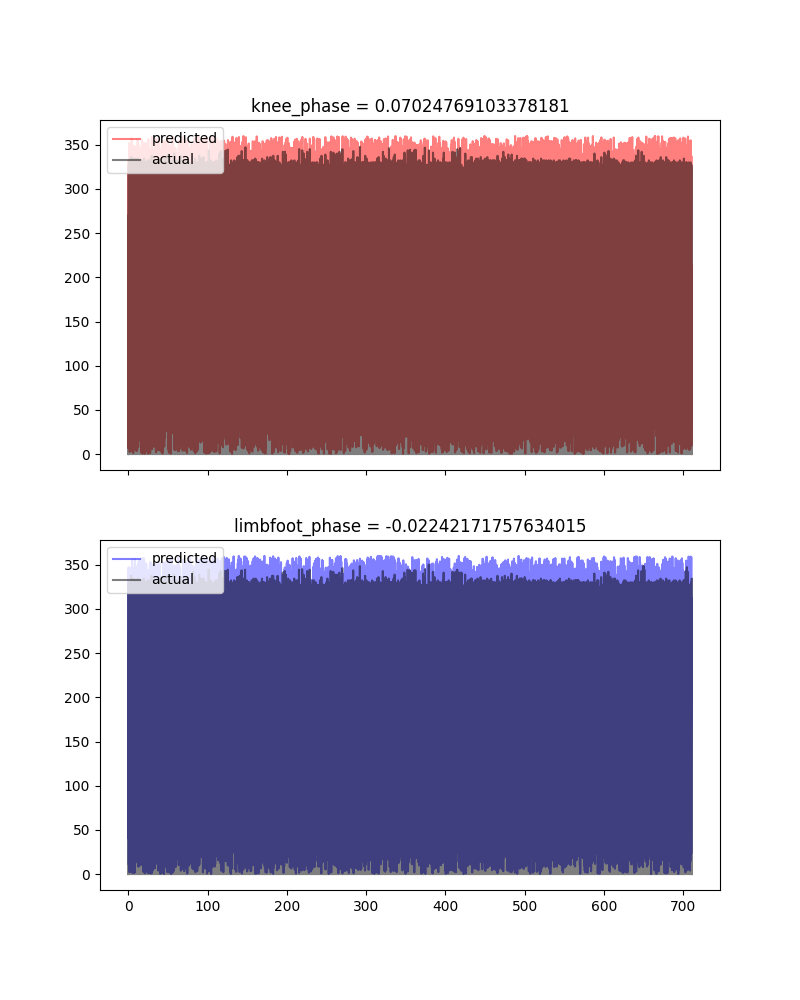

In [27]:
fig512, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('knee_phase = ' + str(vaf(phase_list[:,1],arctans[:,1])))
ax[0].plot(tsf, arctans[:,1], c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[0].legend(loc="upper left")
ax[1].set_title('limbfoot_phase = ' + str(vaf(phase_list[:,3],arctans[:,3])))
ax[1].plot(tsf, arctans[:,3], c='blue', alpha=0.5, label = "predicted")
ax[1].plot(tsf, phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[1].legend(loc="upper left")

In [25]:
test_arctans = arctan_fn(sin_array, cos_array)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
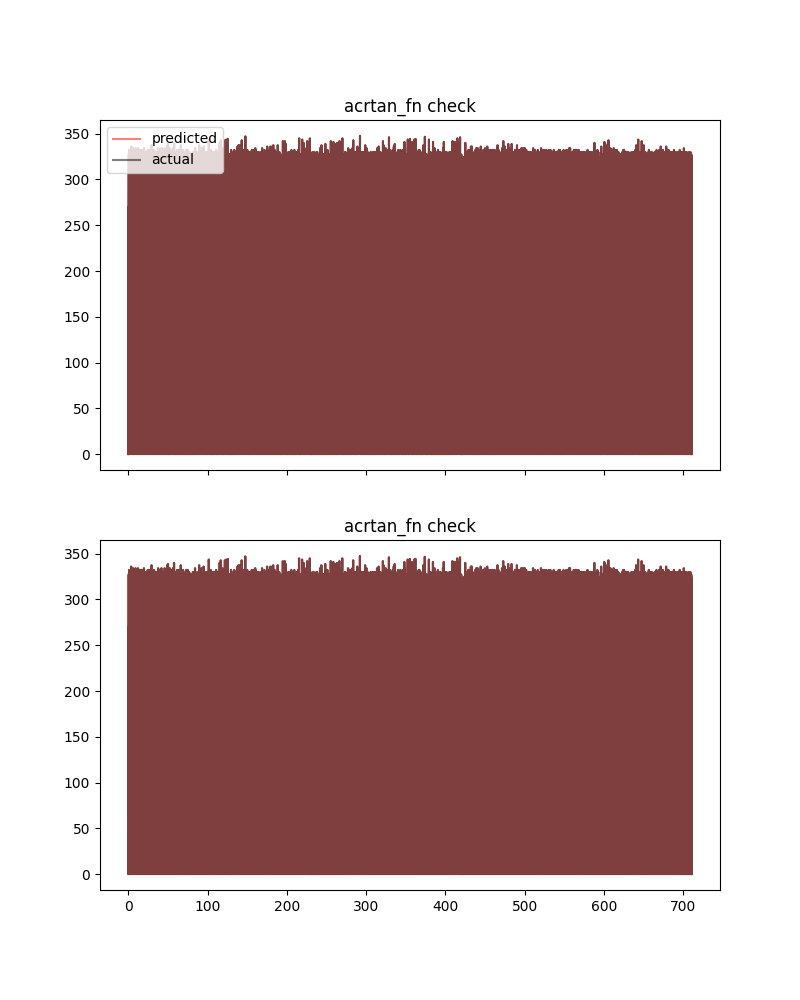

In [26]:
fig5221, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('acrtan_fn check')
ax[0].plot(tsf, test_arctans[:,1], c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, phase_list[:,1], c='k', alpha=0.5, label = "actual")

# ax[0].plot(tsf, predicted_sin[:,3], c='r', alpha=0.5, label = "predicted", linestyle = '--')
ax[0].legend(loc="upper left")
ax[1].set_title('acrtan_fn check')
ax[1].plot(tsf, np.roll(test_arctans[:,1],-6), c='r', alpha=0.5, label = "predicted")
ax[1].plot(tsf, phase_list[:,1], c='k', alpha=0.5, label = "actual")

In [10]:
test_phase = []
for i in range(0,100):
    cycle = np.arange(0,360,1)
    test_phase = np.append(test_phase, cycle)
print(test_phase.shape)
print(test_phase)



(36000,)
[  0.   1.   2. ... 357. 358. 359.]


In [ ]:
plt.figure()  
plt.plot(range(10, 20))
plt.draw()